In [1]:
import sys
print(sys.version)
print(sys.path)

3.7.9 (default, Jan  8 2021, 17:41:21) 
[GCC 7.5.0]
['/home/tokudo/Develop/grips/unicorn/notebooks', '/home/tokudo/.pyenv/versions/3.7.9/lib/python37.zip', '/home/tokudo/.pyenv/versions/3.7.9/lib/python3.7', '/home/tokudo/.pyenv/versions/3.7.9/lib/python3.7/lib-dynload', '', '/home/tokudo/Develop/grips/unicorn/venv/lib/python3.7/site-packages', '/home/tokudo/Develop/grips/grina', '/home/tokudo/Develop/grips/unicorn/venv/lib/python3.7/site-packages/IPython/extensions', '/home/tokudo/.ipython']


In [59]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import grina
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
fpath = os.path.join("..", "data", "unicorn_company_invester.csv")
df = pd.read_csv(fpath, converters={"Select Investors": lambda x: x.split(",")})

In [4]:
def trans2float(x):
    y = x[1:]
    return float(y)

df["Valuation($B) flaot"] = df["Valuation($B)"].apply(trans2float)

In [5]:
df["Valuation($B) flaot"].describe()

count    501.000000
mean       3.185749
std        7.676841
min        1.000000
25%        1.000000
50%        1.500000
75%        3.000000
max      140.000000
Name: Valuation($B) flaot, dtype: float64

In [6]:
df["DateTime Joined"] = df["Date Joined"].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

In [7]:
df.head()

,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
0,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.0,2018-04-18
1,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.0,2018-03-07
2,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.5,2015-07-03
3,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.0,2018-12-19
4,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.0,2015-10-12


In [8]:
def clean(element):
    return element.strip()

In [9]:
r_comps, r_invests = [], []
for company, investors in df[["Company", "Select Investors"]].values.tolist():
    n_rows = len(investors)
    comps = np.full(n_rows, company)
    r_comps += comps.tolist()
    r_invests += investors
r_comps = list(map(clean, r_comps))
r_invests = list(map(clean, r_invests))

In [10]:
# Unicornで投資を行っている企業が存在するため、2部グラフにするためにInvester&Unicornの場合はInvester名に"_"を追加
for i, invest in enumerate(r_invests):
    if invest in r_comps:
        print(invest)
        r_invests[i] = invest + "_"

Didi Chuxing
Bitmain Technologies
Grab
Tokopedia


In [11]:
rdf = pd.DataFrame()
rdf["Company"] = np.array(r_comps)
rdf["Investors"] = np.array(r_invests)
rdf

,Company,Investors
0,100credit,Sequoia Capital China
1,100credit,China Reform Fund
2,100credit,Hillhouse Capital Management
3,17zuoye,DST Global
4,17zuoye,Temasek Holdings
...,...,...
1380,Zwift,True
1381,Zwift,Causeway Media Partners
1382,Zymergen,Data Collective
1383,Zymergen,True Ventures


In [12]:
B = nx.Graph()

In [13]:
B.add_nodes_from(rdf["Company"].unique().tolist(), bipartite=0)
B.add_nodes_from(rdf["Investors"].unique().tolist(), bipartite=1)

In [14]:
edges = [(comp, inve) for comp, inve in zip(rdf["Company"], rdf["Investors"])]
B.add_edges_from(edges)

In [15]:
from networkx.algorithms import bipartite
company_graph = bipartite.projected_graph(B, set(rdf["Company"].tolist()))
investor_graph = bipartite.projected_graph(B, set(rdf["Investors"].tolist()))

In [16]:
company_graph_pd = nx.to_pandas_edgelist(company_graph)

In [17]:
investor_graph_pd = nx.to_pandas_edgelist(investor_graph)

In [18]:
bipartite_graph_pd = nx.to_pandas_edgelist(B)

In [19]:
print("ファイルを出力しますか？[y/n]")
b = input()
if b == "y":
    bipartite_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "bipartite_graph.csv"))
    company_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "company_graph.csv"))
    investor_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "investor_graph.csv"))
    print("Done!!")

ファイルを出力しますか？[y/n]
y
Done!!


# 2部グラフ分析

In [20]:
vc_invest_df = pd.merge(bipartite_graph_pd, df, left_on="source", right_on="Company", how="left")
vc_invest_df.drop(["Select Investors", "source"], axis=1, inplace=True)
vc_invest_df.head()

,target,Company,Valuation($B),Date Joined,Country,Industry,Valuation($B) flaot,DateTime Joined
0,Sequoia Capital China,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
1,China Reform Fund,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
2,Hillhouse Capital Management,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
3,DST Global,17zuoye,$1,3/7/2018,China,Edtech,1.0,2018-03-07
4,Temasek Holdings,17zuoye,$1,3/7/2018,China,Edtech,1.0,2018-03-07


In [21]:
analysis_invest_df = vc_invest_df.groupby("target", as_index=False).agg(
    {
        "Valuation($B) flaot": ["sum", "count", "mean"],
        "Country": [lambda x: len(x.unique()), set],
        "Industry": [lambda x: len(x.unique()), set],
        "Company": [lambda x: len(x.unique()), set],
        "DateTime Joined": "min",
    }
)
analysis_invest_df

target Valuation($B) flaot                Country  \
                                    sum count  mean <lambda_0>   
0       01 Advisors                2.00     1  2.00          1   
1      500 Startups                4.50     2  2.25          2   
2            58.com                3.00     2  1.50          1   
3        5Y Capital                1.22     1  1.22          1   
4           83North               11.55     5  2.31          3   
..              ...                 ...   ...   ...        ...   
690         iFLYTEK                1.00     1  1.00          1   
691  iNovia Capital                1.04     1  1.04          1   
692   iTech Capital                1.00     1  1.00          1   
693  index Ventures                5.50     1  5.50          1   
694          next47                1.60     1  1.60          1   

                                        Industry  \
                                  set <lambda_0>   
0                     {United States}          1   
1            {Philippines, Indonesia}          2   
2                             {China}          1   
3                             {China}          1   
4    {France, Germany, United States}          4   
..                                ...        ...   
690                           {China}          1   
691                   {United States}          1   
692                     {Netherlands}          1   
693                  {United Kingdom}          1   
694                   {United States}          1   

                                                          Company  \
                                                   set <lambda_0>   
0                                            {Fintech}          1   
1             {E-commerce & direct-to-consumer, Other}          2   
2                    {E-commerce & direct-to-consumer}          2   
3                        {Mobile & telecommunications}          1   
4    {Data management & analytics, Fintech, E-comme...          5   
..                                                 ...        ...   
690                                         {Hardware}          1   
691                  {E-commerce & direct-to-consumer}          1   
692                                         {Hardware}          1   
693                                          {Fintech}          1   
694                                    {Cybersecurity}          1   

                                                       DateTime Joined  
                                                   set             min  
0                                            {Tipalti}      2020-10-06  
1                   {Bukalapak, Revolution Precrafted}      2017-10-23  
2                            {Tubatu.com, Zhuan Zhuan}      2015-03-09  
3                                        {GalaxySpace}      2020-11-17  
4    {Marqeta, Celonis, Mirakl, Payoneer, Via Trans...      2017-12-05  
..                                                 ...             ...  
690                              {TERMINUS Technology}      2018-10-25  
691                                        {AppDirect}      2015-10-07  
692                                          {BitFury}      2018-11-06  
693                                          {Revolut}      2018-04-26  
694                                          {Verkada}      2020-01-29  

[695 rows x 11 columns]

In [22]:
columns = ["Investor", "Total valuation($B)", "Valuation count", "Mean valuation($B)", "#countries", "Country set", "#industries", "Industry set", "#unicorns", "Unicorn set", "Oldest datetime joined"]
analysis_invest_df.columns = analysis_invest_df.columns.to_flat_index()
analysis_invest_df.columns = columns
analysis_invest_df.head()

,Investor,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,01 Advisors,2.00,1,2.00,1,{United States},1,{Fintech},1,{Tipalti},2020-10-06
1,500 Startups,4.50,2,2.25,2,"{Philippines, Indonesia}",2,"{E-commerce & direct-to-consumer, Other}",2,"{Bukalapak, Revolution Precrafted}",2017-10-23
2,58.com,3.00,2,1.50,1,{China},1,{E-commerce & direct-to-consumer},2,"{Tubatu.com, Zhuan Zhuan}",2015-03-09
3,5Y Capital,1.22,1,1.22,1,{China},1,{Mobile & telecommunications},1,{GalaxySpace},2020-11-17
4,83North,11.55,5,2.31,3,"{France, Germany, United States}",4,"{Data management & analytics, Fintech, E-comme...",5,"{Marqeta, Celonis, Mirakl, Payoneer, Via Trans...",2017-12-05


In [23]:
analysis_invest_df.to_csv(os.path.join("..", "out", "features", "investment_info.csv"))

# 中心性
## 投資家のグラフ

In [24]:
def get_centrality(G):
    degrees = nx.degree_centrality(G)
    betweens = nx.betweenness_centrality(G)
    eigens = nx.eigenvector_centrality(G, max_iter=1000)
    closeness = nx.closeness_centrality(G)
    page_ranks = nx.pagerank(G, max_iter=1000)
    centra_dict = {
        "Degree Centrality": degrees,
        "Betweenness Centrality": betweens,
        "Eigen Centrality": eigens,
        "Closeness Centrality": closeness,
        "Page Rank": page_ranks,
    }
    if type(G) == nx.DiGraph:
        in_degrees = nx.in_degree_centrality(G)
        out_degrees = nx.out_degree_centrality(G)
        elongations = grina.get_elongation(G)
        expansions = grina.get_degree_expansion(G)
        teacher_discs = grina.node_teacher_disciple_degree(G)
        colleagues = grina.node_colleague_degree(G)
        unidir_density = grina.node_unidirect_density(G)
        bidir_density = grina.node_bidirect_density(G)
        centra_dict["In-degree Centrality"] = in_degrees
        centra_dict["Out-degree Centrality"] = out_degrees
        centra_dict["Elongation"] = elongations
        centra_dict["Expansion"] = expansions
        centra_dict["Teacher Disciple Degree"] = teacher_discs
        centra_dict["Colleague Degree"] = colleagues
        centra_dict["Unidirect Density"] = unidir_density
        centra_dict["Bidirect Density"] = bidir_density
    return pd.DataFrame.from_dict(centra_dict)

In [25]:
investor_centrality_df = get_centrality(investor_graph).reset_index().rename({"index": "Investor"}, axis=1)
investor_centrality_df = pd.merge(investor_centrality_df, analysis_invest_df, on="Investor")
investor_centrality_df

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,Ant Financial Services Group,0.004323,0.000932,9.175387e-03,0.186534,0.001153,9.00,2,4.500000,1,{China},2,"{Artificial intelligence, Auto & transportation}",2,"{MEGVII, Hello TransTech}",2018-06-01
1,BOLDstart Ventures,0.002882,0.000000,3.027680e-02,0.205982,0.000703,2.60,1,2.600000,1,{United States},1,{Cybersecurity},1,{Snyk},2020-01-21
2,Cowboy Ventures,0.002882,0.000000,1.850065e-02,0.196614,0.000832,1.00,1,1.000000,1,{United States},1,{Mobile & telecommunications},1,{Branch},2018-09-10
3,Polaris Partners,0.002882,0.000000,7.076364e-03,0.169811,0.000746,3.00,1,3.000000,1,{United States},1,{Internet software & services},1,{Automattic},2013-05-27
4,Investment Corporation of Dubai,0.001441,0.000000,1.583809e-20,0.001441,0.001475,1.00,1,1.000000,1,{Switzerland},1,{Fintech},1,{Numbrs},2019-08-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,Clermont Group,0.002882,0.000000,1.777468e-16,0.002882,0.001475,2.80,1,2.800000,1,{United Kingdom},1,{Fintech},1,{OakNorth},2017-10-12
691,New Enterprise Associates,0.048991,0.064035,2.037530e-01,0.269013,0.010280,47.28,18,2.626667,3,"{China, Germany, United States}",9,"{E-commerce & direct-to-consumer, Artificial i...",18,"{Houzz, Branch, Instabase, Intarcia Therapeuti...",2014-04-01
692,Activant Capital Group,0.002882,0.000000,3.632638e-03,0.161882,0.000933,3.50,1,3.500000,1,{United States},1,{Artificial intelligence},1,{Indigo Ag},2017-09-26
693,Group 11,0.002882,0.000000,3.360952e-03,0.164933,0.000881,2.00,1,2.000000,1,{United States},1,{Fintech},1,{Tipalti},2020-10-06


## 企業のネットワーク


In [26]:
company_centrality_df = get_centrality(company_graph)
company_centrality_df = company_centrality_df.reset_index().rename({"index": "Company"},axis=1) 
company_centrality_df = pd.merge(company_centrality_df, df, on="Company")
company_centrality_df.head()

,Company,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
0,GPclub,0.030,0.000000,0.017960,0.306837,0.002023,$1.32,10/22/2018,South Korea,Other,[Goldman Sachs],1.32,2018-10-22
1,Mofang Living,0.014,0.006637,0.006681,0.248644,0.001949,$1.50,4/13/2016,China,E-commerce & direct-to-consumer,"[Warburg Pincus, Aviation Industry Corporatio...",1.50,2016-04-13
2,Upgrade,0.020,0.002269,0.003705,0.271460,0.001803,$1,6/17/2020,United States,Fintech,"[Union Square Ventures, Ribbit Capital, VY C...",1.00,2020-06-17
3,Docker,0.044,0.002487,0.017484,0.323167,0.002717,$1.30,4/14/2015,United States,Internet software & services,"[Greylock Partners, Lightspeed Venture Partne...",1.30,2015-04-14
4,Zipline International,0.074,0.007014,0.033535,0.335380,0.004214,$1.20,5/20/2019,United States,"Supply chain, logistics, & delivery","[Sequoia Capital, Baillie Gifford & Co., Goo...",1.20,2019-05-20


## 企業メモ
* Pony.aiは自動運転自動車の会社
* Ziroomは賃貸掲載サイトの運営会社（スーモやホームズみたいなサイトの中国版？）
* Rappiはコロンビアの会社で、買い物代行。Uber eatに近いサービスだと思う。

# コンポーネント

In [27]:
def describe_components(G):
    n_comps = nx.number_connected_components(G)
    print("コンポーネント数: {}".format(n_comps))
    print("ノード数に対するコンポーネント数の割合: {0:.2%}".format(n_comps / len(G)))
    S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    comp_sizes = [len(s) for s in S]
    print("投資家コンポーネント上位10件のサイズ")
    print(np.sort(comp_sizes)[::-1][:10])
    comp_sizes = np.sort(comp_sizes)[::-1]
    plt.plot(comp_sizes)
    print("ネットワーク密度: {0:.2%}".format(nx.density(S[0])))

コンポーネント数: 82
ノード数に対するコンポーネント数の割合: 11.80%
投資家コンポーネント上位10件のサイズ
[506   7   4   3   3   3   3   3   3   3]
ネットワーク密度: 0.85%


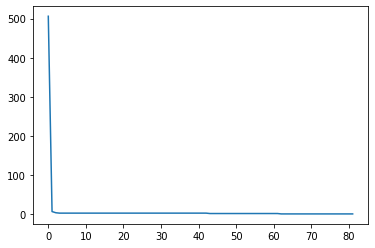

In [28]:
describe_components(investor_graph)

コンポーネント数: 82
ノード数に対するコンポーネント数の割合: 16.37%
投資家コンポーネント上位10件のサイズ
[417   3   2   1   1   1   1   1   1   1]
ネットワーク密度: 4.16%


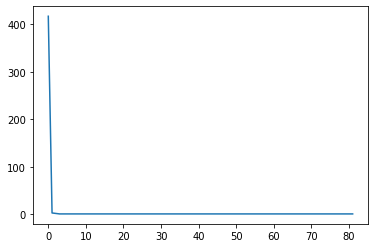

In [29]:
describe_components(company_graph)

## 企業 - 国・産業ネットワーク

In [28]:
country_industry_df = pd.merge(company_graph_pd, df[["Company", "Country", "Industry"]], left_on="source", right_on="Company", how="left")
country_industry_df = pd.merge(country_industry_df, df[["Company", "Country", "Industry"]], left_on="target", right_on="Company", how="left", suffixes=["_source", "_target"])
country_industry_df = country_industry_df.drop(["Company_source", "Company_target"], axis=1)
country_industry_df.head()

,source,target,Country_source,Industry_source,Country_target,Industry_target
0,HashiCorp,Apus Group,United States,Internet software & services,China,Mobile & telecommunications
1,HashiCorp,Arctic Wolf Networks,United States,Internet software & services,United States,Cybersecurity
2,HashiCorp,Outreach,United States,Internet software & services,United States,Artificial intelligence
3,HashiCorp,Guild Education,United States,Internet software & services,United States,Internet software & services
4,HashiCorp,Grove Collaborative,United States,Internet software & services,United States,E-commerce & direct-to-consumer


In [54]:
country_graph_df = country_industry_df.groupby(by=["Country_source", "Country_target"], as_index=False).agg({'source': 'count'})
country_graph_df.columns = ["source", "target", "weight"]
country_G = nx.from_pandas_edgelist(
    country_graph_df, create_using=nx.Graph, edge_attr=["weight"]
)
country_graph_df = nx.to_pandas_edgelist(country_G)
country_graph_df.to_csv(os.path.join("..", "out", "edgelist", "contry_graph.csv"))
country_graph_matrix = nx.to_pandas_adjacency(country_G)
country_graph_matrix.to_csv(os.path.join("..", "out", "adjacency", "contry_graph.csv"))

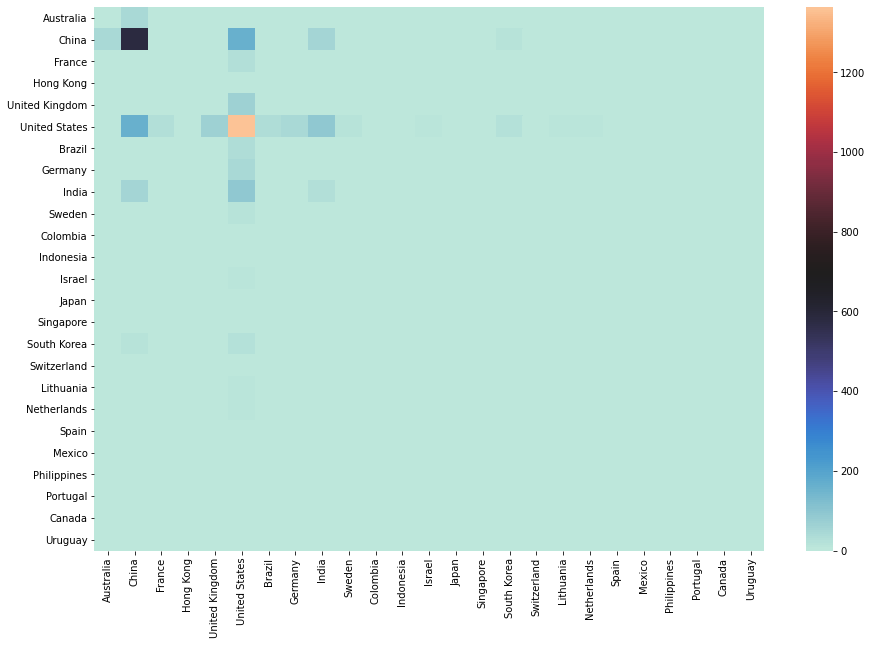

In [71]:
plt.figure(figsize=(15, 10))
sns.heatmap(country_graph_matrix, center=700)
plt.savefig(os.path.join("..", "out", "adjacency", "country_graph.png"))

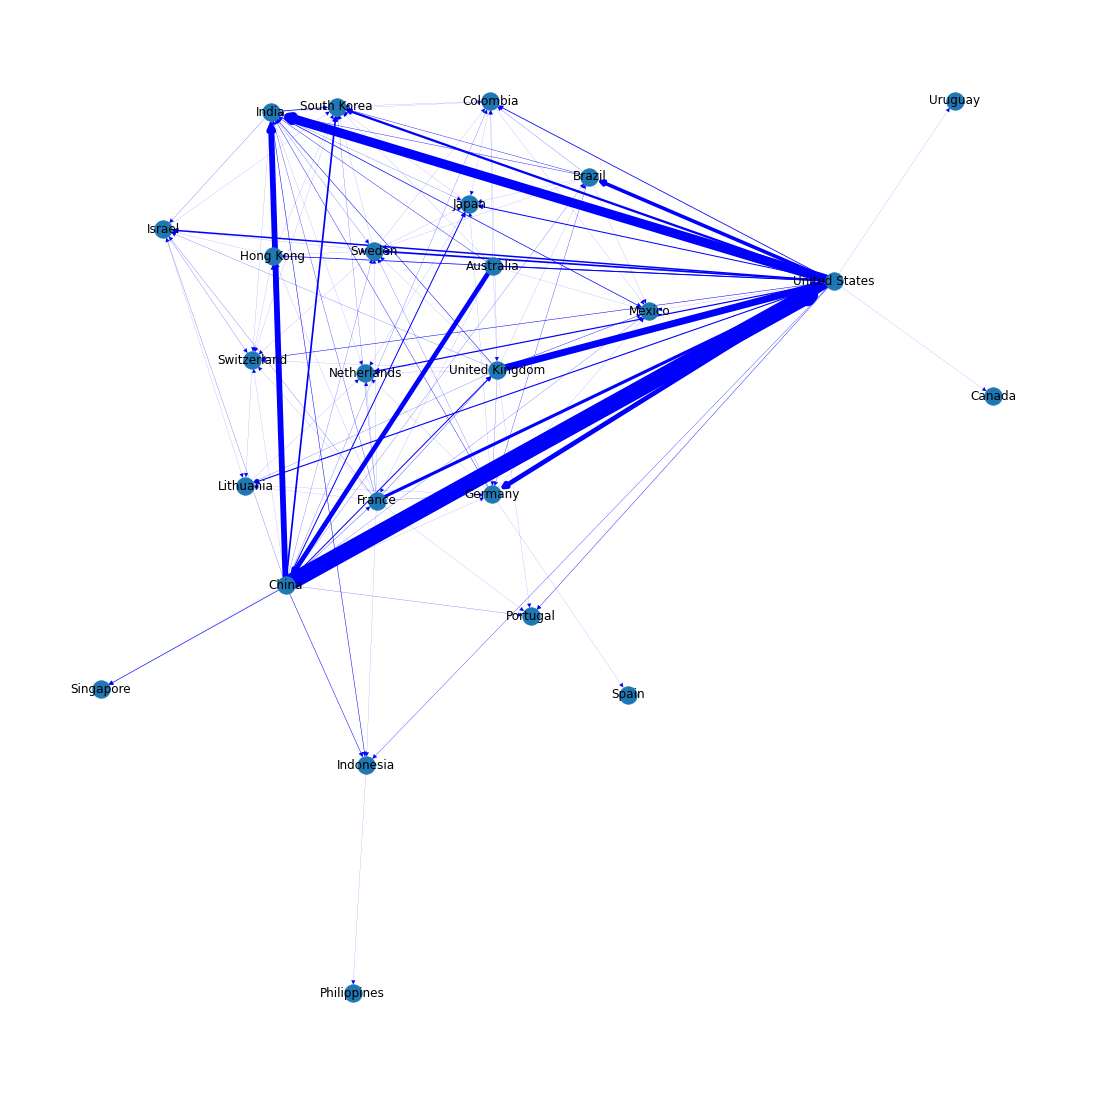

In [78]:
country_DG = nx.from_pandas_edgelist(
    country_graph_df, create_using=nx.DiGraph, edge_attr=["weight"]
)
edge_widths = [d['weight']/10 for _,_,d in country_DG.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    country_DG, width=edge_widths,
    pos=nx.kamada_kawai_layout(country_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join("..", "out", "edgelist", "country_dgraph.png"))

In [77]:
country_dgraph_matrix = nx.to_pandas_adjacency(country_DG)
country_dgraph_matrix.to_csv(os.path.join("..", "out", "adjacency", "country_dgraph.csv"))

In [55]:
industry_graph_df = country_industry_df.groupby(by=["Industry_source", "Industry_target"], as_index=False).agg({"source": 'count'})
industry_graph_df.columns = ["source", "target", "weight"]
industry_G = nx.from_pandas_edgelist(industry_graph_df, create_using=nx.Graph, edge_attr="weight")
industry_graphd_df = nx.to_pandas_edgelist(industry_G)
industry_graph_df.to_csv(os.path.join("..", "out", "edgelist", "industry_graph.csv"))
industry_graph_matrix = nx.to_pandas_adjacency(industry_G)
industry_graph_matrix.to_csv(os.path.join("..", "out", "adjacency", "industry_graph.csv"))
industry_graph_df.head()

,source,target,weight
0,Artificial intelligence,Artificial intelligence,20
1,Artificial intelligence,Auto & transportation,15
2,Artificial intelligence,Consumer & retail,7
3,Artificial intelligence,Cybersecurity,8
4,Artificial intelligence,Data management & analytics,17


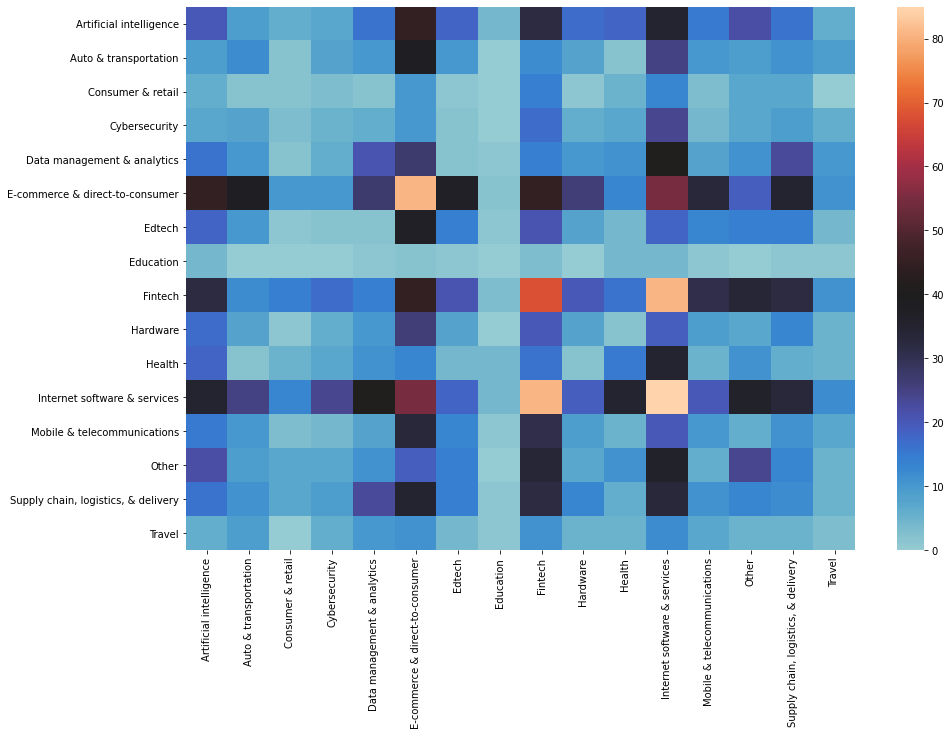

In [72]:
plt.figure(figsize=(15, 10))
sns.heatmap(industry_graph_matrix, center=40)
plt.savefig(os.path.join("..", "out", "adjacency", "industry_graph.png"))

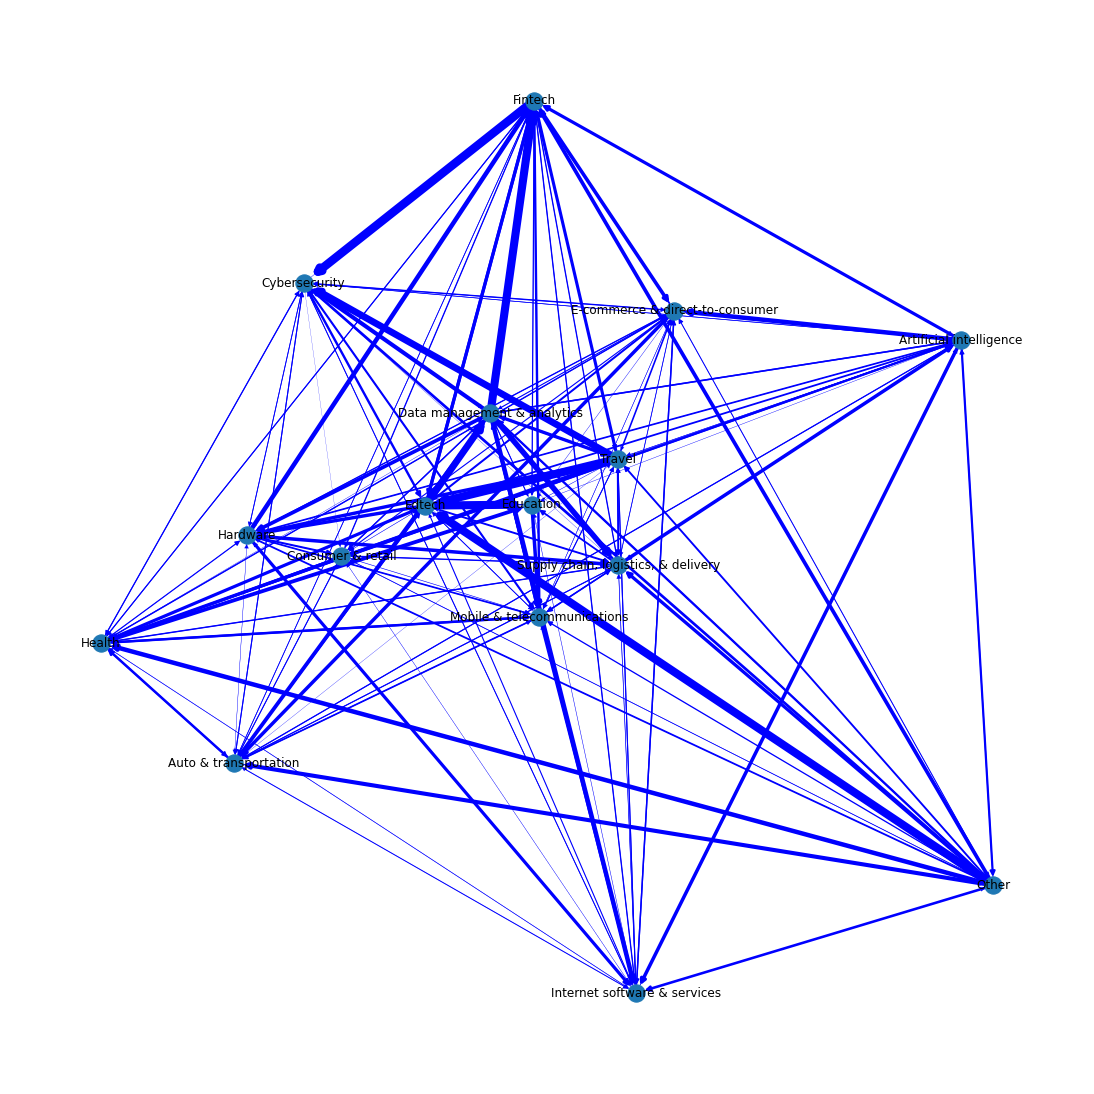

In [79]:
industry_DG = nx.from_pandas_edgelist(industry_graph_df, create_using=nx.DiGraph, edge_attr="weight")
edge_width = [v["weight"] * 0.1 for _, _, v in industry_G.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    industry_DG, width=edge_width, pos=nx.kamada_kawai_layout(industry_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join("..", "out", "edgelist", "industry_dgraph.png"))

In [75]:
industry_dgraph_matrix = nx.to_pandas_adjacency(industry_DG)
industry_dgraph_matrix.to_csv(os.path.join("..", "out", "adjacency", "industry_dgraph.csv"))

In [35]:
country_centrality_df = get_centrality(country_G)
industry_centrality_df = get_centrality(industry_G)

In [36]:
country_centrality_df.to_csv(os.path.join("..", "out", "features", "country_unicorn_centrality.csv"))

In [37]:
industry_centrality_df.to_csv(os.path.join("..", "out", "features", "industry_unicorn_centrality.csv"))

# 基本情報の出力
国ごとのバリュエーション、Industryごとのバリュエーションを出力

In [38]:
df.sort_values(by=["Date Joined"])

,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
255,LinkSure Network,$1,1/1/2015,China,Mobile & telecommunications,[N/A],1.00,2015-01-01
242,Kuaishou,$18,1/1/2015,China,Mobile & telecommunications,"[Morningside Venture Capital, Sequoia Capital...",18.00,2015-01-01
244,L&P Cosmetic,$1.19,1/1/2016,South Korea,Consumer & retail,[CDIB Capital],1.19,2016-01-01
418,Traveloka,$3,1/1/2017,Indonesia,Travel,"[Global Founders Capital, East Ventures, Exp...",3.00,2017-01-01
24,AppLovin,$2,1/1/2017,United States,Mobile & telecommunications,"[Orient Hontai Capital, Webb Investment Network]",2.00,2017-01-01
...,...,...,...,...,...,...,...,...
275,Mia.com,$1,9/8/2015,China,E-commerce & direct-to-consumer,"[Sequoia Capital China, ZhenFund, K2 Ventures]",1.00,2015-09-08
302,OfferUp,$1.20,9/8/2016,United States,Mobile & telecommunications,"[Andreessen Horowitz, GGV Capital, T. Rowe P...",1.20,2016-09-08
280,Mollie,$1,9/8/2020,Netherlands,Fintech,[Technology Crossover Ventures],1.00,2020-09-08
460,WEMAKEPRICE,$2.34,9/9/2015,South Korea,E-commerce & direct-to-consumer,"[IMM Investment, NXC]",2.34,2015-09-09


In [39]:
stat_ind = ["mean", "sum", "min", "max", "count"]

In [40]:
country_group = df.groupby("Country").agg(stat_ind)
country_group.head()
cg_df = pd.DataFrame(country_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=country_group.index)
cg_df.sort_values(by=["sum"], ascending=False, inplace=True)
cg_df.head()

,mean,sum,min,max,count
Country,,,,,
United States,2.954321,717.90,1.0,46.00,243.0
China,4.379661,516.80,1.0,140.00,118.0
India,3.510400,87.76,1.0,16.00,25.0
United Kingdom,2.728750,65.49,1.0,11.08,24.0
South Korea,2.761818,30.38,1.0,9.00,11.0


In [41]:
industry_group = df.groupby("Industry").agg(stat_ind)
industry_group.head()
ig_df = pd.DataFrame(industry_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=industry_group.index)
ig_df.sort_values(by=["sum"], ascending=False, inplace=True)
ig_df.head()

,mean,sum,min,max,count
Industry,,,,,
Fintech,3.513099,249.43,1.0,36.0,71.0
Artificial intelligence,5.386444,242.39,1.0,140.0,45.0
E-commerce & direct-to-consumer,2.683594,171.75,1.0,15.0,64.0
Auto & transportation,4.915357,137.63,1.0,62.0,28.0
Internet software & services,2.047656,131.05,1.0,6.0,64.0


In [42]:
y = cg_df["mean"].values
x = cg_df.index.to_numpy()

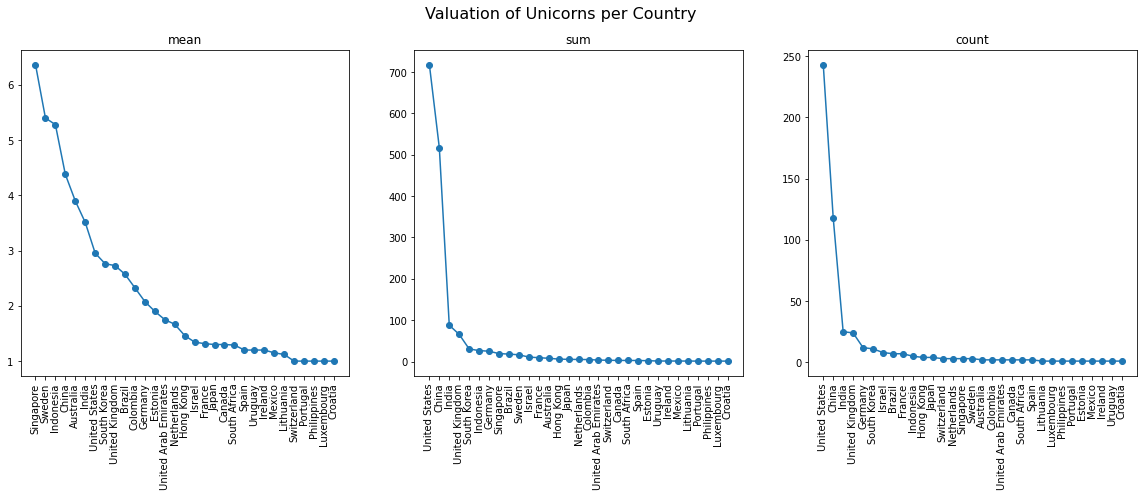

Complete output to ../out/features/value_per_country.png


In [43]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Country", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    cg_df.sort_values(by=[col], ascending=False, inplace=True)
    y = cg_df[col].values
    x = cg_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join("..", "out", "features", "value_per_country.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

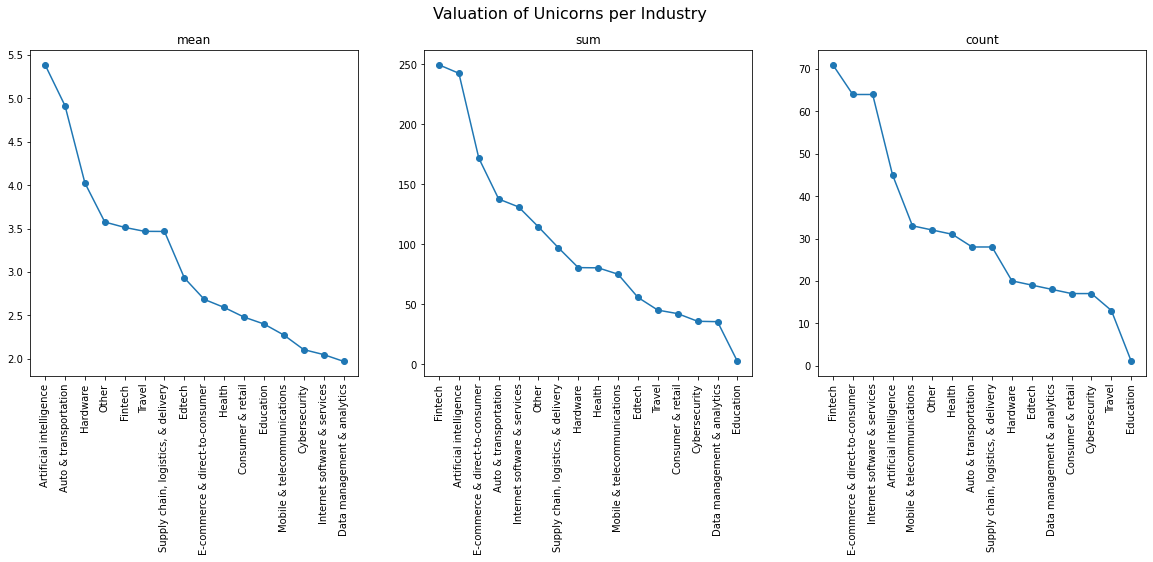

Complete output to ../out/features/value_per_industry.png


In [44]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Industry", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    ig_df.sort_values(by=[col], ascending=False, inplace=True)
    y = ig_df[col].values
    x = ig_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join("..", "out", "features", "value_per_industry.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

# 時系列可視化

In [45]:
print(len(df))
tdf = df.set_index("DateTime Joined")
tdf

501


,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot
DateTime Joined,,,,,,,
2018-04-18,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.00
2018-03-07,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.00
2015-07-03,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.50
2018-12-19,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.00
2015-10-12,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.00
...,...,...,...,...,...,...,...
2015-04-10,Zomato,$3.60,4/10/2015,India,Internet software & services,"[Sequoia Capital, VY Capital]",3.60
2018-11-01,Zume,$2.25,11/1/2018,United States,Consumer & retail,"[Softbank Group, AME Cloud Ventures, SignalF...",2.25
2018-07-18,Zuoyebang,$2,7/18/2018,China,Edtech,"[Sequoia Capital China, Xiang He Capital, GG...",2.00


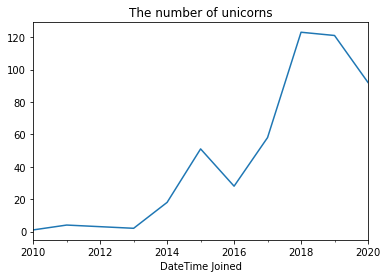

In [46]:
gdf = df.groupby(pd.Grouper(key="DateTime Joined", freq="Y")).agg("count")
gdf = gdf.reset_index().set_index("DateTime Joined")
gdf["Company"].plot(title="The number of unicorns")
plt.savefig(os.path.join("..", "out", "features", "n_unicorns_time_change.png"))

# ネットワークに時系列の要素を追加
カンパニーグラフは知識の流れを表していると解釈することができる。Date Joinedが遅い企業は、早い企業から知識を共有されていると考える。
そうした場合にどこの企業からどこの企業にVCを介して知識が伝播しているかを可視化する。

## ユニコーンネットワーク

In [47]:
company_graph_pd

,source,target
0,GPclub,Infinidat
1,GPclub,VAST Data
2,GPclub,Voodoo
3,GPclub,Klook
4,GPclub,Northvolt
...,...,...
3605,FiveTran,Cazoo
3606,Affirm,Rocket Lab
3607,Leap Motor,Bytedance
3608,Leap Motor,Tubatu.com


In [48]:
uc_date = df[["Company", "Date Joined", "Country", "Industry", "Valuation($B) flaot"]]
datetime_s = uc_date["Date Joined"].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
uc_date["DateTime Joined"] = datetime_s
uc_date = uc_date.set_index("Company")
elem_dict = uc_date.to_dict("index")

/Users/tokudo/Develop/grips/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
uc_date.head()

,Date Joined,Country,Industry,Valuation($B) flaot,DateTime Joined
Company,,,,,
100credit,4/18/2018,China,Fintech,1.0,2018-04-18
17zuoye,3/7/2018,China,Edtech,1.0,2018-03-07
23andMe,7/3/2015,United States,Health,2.5,2015-07-03
4Paradigm,12/19/2018,China,Artificial intelligence,2.0,2018-12-19
58 Daojia,10/12/2015,China,Internet software & services,1.0,2015-10-12


In [50]:
sources = []
targets = []
for source, target in company_graph_pd.values:
        if elem_dict[source]["DateTime Joined"] > elem_dict[target]["DateTime Joined"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
comp_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
comp_dgraph_df

,source,target
0,Infinidat,GPclub
1,GPclub,VAST Data
2,GPclub,Voodoo
3,Klook,GPclub
4,GPclub,Northvolt
...,...,...
3605,Cazoo,FiveTran
3606,Rocket Lab,Affirm
3607,Bytedance,Leap Motor
3608,Tubatu.com,Leap Motor


In [51]:
# チェック用
print(elem_dict["Flexport"]["Date Joined"])
print(elem_dict["Knotel"]["Date Joined"])
print(elem_dict["Gong"]["Date Joined"])
print(elem_dict["VAST Data"]["Date Joined"])
print(elem_dict["Dave"]["Date Joined"])
print(elem_dict["Udemy"]["Date Joined"])

4/30/2018
8/21/2019
8/12/2020
4/16/2020
9/30/2019
2/19/2020


In [52]:
comp_dgraph = nx.from_pandas_edgelist(comp_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [53]:
# 国・産業ごとにノードに色付けのためのCMAP生成
cmap = plt.get_cmap("tab20b")
country_l = df["Country"].unique()
industry_l = df["Industry"].unique()
country_cmap = []
industry_cmap = []
val_size = []
max_val = df["Valuation($B) flaot"].max()
min_val = df["Valuation($B) flaot"].min()
diff = max_val - min_val
for n in comp_dgraph.nodes():
    industry = elem_dict[n]["Industry"]
    ind_idx = np.where(industry_l == industry)
    country = elem_dict[n]["Country"]
    cou_idx = np.where(country_l == country)
    industry_cmap.append(cmap(ind_idx))
    country_cmap.append(cmap(cou_idx))
    val_size.append(
        100 + (elem_dict[n]["Valuation($B) flaot"] - min_val)/diff*900
    )

In [54]:
country_cmap = list(map(lambda x: tuple(x[0][0]), country_cmap))
industry_cmap = list(map(lambda x: tuple(x[0][0]), industry_cmap))

In [55]:
val_size[:10]

[103.88489208633094,
 102.07194244604317,
 101.29496402877697,
 102.58992805755396,
 102.26618705035972,
 116.51079136690647,
 137.55395683453236,
 103.88489208633094,
 100.45323741007195,
 108.35251798561151]

In [56]:
# plt.figure(figsize=(100, 100))
# nx.draw_circular(comp_dgraph, font_size=8, node_size=val_size, node_color=country_cmap)
# plt.savefig(os.path.join("..", "out", "sen2jun_dgraph"))

In [57]:
comp_dgraph_centrality_df = get_centrality(comp_dgraph)
comp_dgraph_centrality_df = comp_dgraph_centrality_df.reset_index().rename({"index": "Company"}, axis=1)
comp_dgraph_centrality_df.head()
comp_dgraph_centrality_df = pd.merge(comp_dgraph_centrality_df, df, on="Company", how="left")

In [58]:
comp_dgraph_centrality_df.to_csv(os.path.join("..", "out", "features", "directed_unicorn_centrality.csv"))

## VCネットワーク

In [59]:
investor_graph_pd

,source,target
0,Ant Financial Services Group,Russia-China Investment Fund
1,Ant Financial Services Group,Foxconn Technology Company
2,Ant Financial Services Group,GGV Capital
3,BOLDstart Ventures,Google Ventures
4,BOLDstart Ventures,Accel
...,...,...
1235,Baidu,IDG Capital
1236,Kleiner Perkins Caufield & Byers,New Enterprise Associates
1237,IDG Capital,Gaorong Capital
1238,IDG Capital,Bitmain Technologies_


In [61]:
datetime_df = analysis_invest_df[["Investor", "Oldest datetime joined"]]
datetime_df.columns = ["investor", "datetime"]
elem_dict = datetime_df.set_index("investor").to_dict("index")

In [62]:
sources = []
targets = []
for source, target in investor_graph_pd.values:
        if elem_dict[source]["datetime"] > elem_dict[target]["datetime"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
investor_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
investor_dgraph_df

,source,target
0,Ant Financial Services Group,Russia-China Investment Fund
1,Foxconn Technology Company,Ant Financial Services Group
2,GGV Capital,Ant Financial Services Group
3,Google Ventures,BOLDstart Ventures
4,Accel,BOLDstart Ventures
...,...,...
1235,Baidu,IDG Capital
1236,Kleiner Perkins Caufield & Byers,New Enterprise Associates
1237,IDG Capital,Gaorong Capital
1238,IDG Capital,Bitmain Technologies_


In [63]:
investor_dgraph = nx.from_pandas_edgelist(investor_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [64]:
investor_dgraph_centrality_df = get_centrality(investor_dgraph)
investor_dgraph_centrality_df = investor_dgraph_centrality_df.reset_index().rename({"index": "Investor"}, axis=1)
investor_dgraph_centrality_df = pd.merge(investor_dgraph_centrality_df, analysis_invest_df, on="Investor", how="left")
investor_dgraph_centrality_df.to_csv(os.path.join("..", "out", "features", "directed_investor_centrality.csv"))
investor_dgraph_centrality_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,...,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,Ant Financial Services Group,0.004451,0.000036,8.923545e-22,0.013091,0.001670,0.002967,0.001484,1,1,...,9.00,2,4.500,1,{China},2,"{Artificial intelligence, Auto & transportation}",2,"{MEGVII, Hello TransTech}",2018-06-01
1,Russia-China Investment Fund,0.002967,0.000000,3.039474e-20,0.011784,0.003002,0.002967,0.000000,0,0,...,4.00,1,4.000,1,{China},1,{Artificial intelligence},1,{MEGVII},2018-07-01
2,Foxconn Technology Company,0.005935,0.000049,5.157235e-30,0.009088,0.001715,0.002967,0.002967,1,2,...,7.00,2,3.500,2,"{China, United States}",2,"{Artificial intelligence, Supply chain, logist...",2,"{MEGVII, Katerra}",2017-04-13
3,GGV Capital,0.026706,0.004240,2.427577e-23,0.013353,0.001443,0.005935,0.020772,7,317,...,41.15,10,4.115,3,"{Singapore, China, United States}",7,"{Fintech, E-commerce & direct-to-consumer, Aut...",10,"{Kujiale, Zuoyebang, Hello TransTech, Keep, Of...",2014-12-04
4,Google Ventures,0.038576,0.002895,8.271635e-16,0.028500,0.001613,0.013353,0.025223,5,149,...,40.50,15,2.700,1,{United States},8,"{Fintech, Cybersecurity, E-commerce & direct-t...",15,"{Podium, Gusto, Robinhood, Turo, Carbon, Toast...",2015-07-03


In [65]:
value_df = df[["Company", "Valuation($B) flaot"]]
value_df.head()

,Company,Valuation($B) flaot
0,100credit,1.0
1,17zuoye,1.0
2,23andMe,2.5
3,4Paradigm,2.0
4,58 Daojia,1.0


In [78]:
unicorn_data_df = pd.merge(comp_dgraph_centrality_df, value_df, on="Company", how="left").set_index("Company")

In [79]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Infinidat,0.045131,0.001557,3.211266e-50,0.006578,0.000852,0.002375,0.042755,7,261,1.0,...,0.022512,0.0,$1.60,4/29/2015,United States,Hardware,"[TPG Growth, Goldman Sachs]",1.60,2015-04-29,1.60
GPclub,0.035629,0.000000,2.586546e-20,0.109565,0.001582,0.023753,0.011876,6,28,1.0,...,0.017773,0.0,$1.32,10/22/2018,South Korea,Other,[Goldman Sachs],1.32,2018-10-22,1.32
VAST Data,0.054632,0.001159,2.404586e-07,0.173483,0.005293,0.047506,0.007126,2,4,1.0,...,0.027251,0.0,$1.20,4/16/2020,United States,Data management & analytics,"[Norwest Venture Partners, Goldman Sachs, De...",1.20,2020-04-16,1.20
Voodoo,0.085511,0.000213,2.191322e-06,0.207209,0.010985,0.083135,0.002375,1,1,1.0,...,0.042654,0.0,$1.40,8/17/2020,France,Other,"[Tencent Holdings, Goldman Sachs]",1.40,2020-08-17,1.40
Klook,0.106888,0.006355,1.860517e-21,0.138383,0.002824,0.071259,0.035629,7,68,1.0,...,0.053318,0.0,$1.35,8/7/2018,Hong Kong,Travel,"[Sequoia Capital China, Goldman Sachs, Matri...",1.35,2018-08-07,1.35


In [80]:
unicorn_data_df.corr()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Valuation($B) flaot_x,Valuation($B) flaot_y
Degree Centrality,1.000000,0.633383,-0.004594,0.331737,0.172589,0.692668,0.720341,0.307257,0.320264,NaN,NaN,1.000000,NaN,0.123001,0.123001
Betweenness Centrality,0.633383,1.000000,-0.030586,0.170840,-0.034635,0.396861,0.496511,0.265505,0.174306,NaN,NaN,0.633383,NaN,0.058813,0.058813
Eigen Centrality,-0.004594,-0.030586,1.000000,0.123220,0.478707,0.048391,-0.052906,-0.086088,-0.050707,NaN,NaN,-0.004594,NaN,-0.014008,-0.014008
Closeness Centrality,0.331737,0.170840,0.123220,1.000000,0.634497,0.784401,-0.294401,-0.412150,-0.569440,NaN,NaN,0.331737,NaN,-0.143888,-0.143888
Page Rank,0.172589,-0.034635,0.478707,0.634497,1.000000,0.524176,-0.264802,-0.379324,-0.334031,NaN,NaN,0.172589,NaN,-0.077158,-0.077158
In-degree Centrality,0.692668,0.396861,0.048391,0.784401,0.524176,1.000000,-0.001321,-0.121005,-0.304355,NaN,NaN,0.692668,NaN,-0.063922,-0.063922
Out-degree Centrality,0.720341,0.496511,-0.052906,-0.294401,-0.264802,-0.001321,1.000000,0.542370,0.736728,NaN,NaN,0.720341,NaN,0.232009,0.232009
Elongation,0.307257,0.265505,-0.086088,-0.412150,-0.379324,-0.121005,0.542370,1.000000,0.668685,NaN,NaN,0.307257,NaN,0.102519,0.102519
Expansion,0.320264,0.174306,-0.050707,-0.569440,-0.334031,-0.304355,0.736728,0.668685,1.000000,NaN,NaN,0.320264,NaN,0.251708,0.251708
Teacher Disciple Degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


valuationとユニコーン有向ネットワークの中心性との間に相関は見られない。

* 国ごと産業ごとの比較。
* 名寄せの問題。これは細かいので後回し
* 仮説を立てる。
  * VCのネットワークの意味は？
    * 何の関係を表してる？情報の流れ？
  * ユニコーンのネットワークの意味は？
    * 情報の流れ

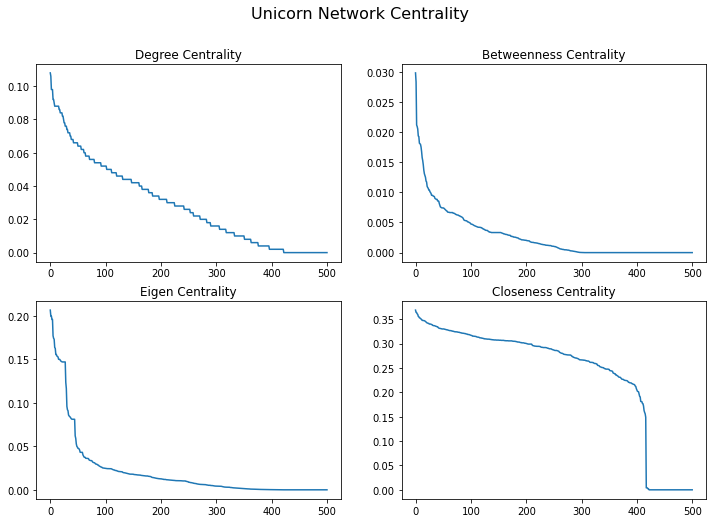

In [69]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Unicorn Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "unicorn_network_centrality.png"))

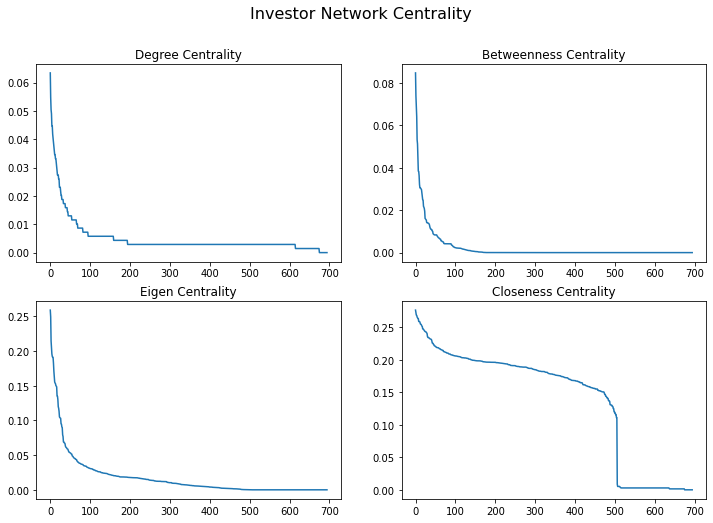

In [70]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Investor Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "investor_network_centrality.png"))

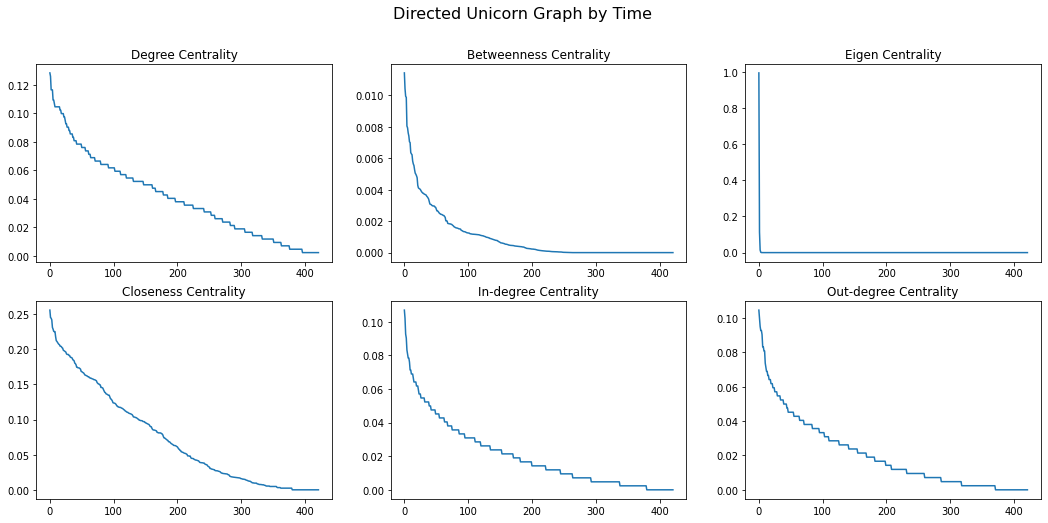

In [71]:
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Directed Unicorn Graph by Time", fontsize=16)
ax1 = fig.add_subplot(231)
col = "Degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(232)
col = "Betweenness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(233)
col = "Eigen Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(234)
col = "Closeness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
ax5 = fig.add_subplot(235)
col = "In-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax5.set_title(col)
ax5.plot(x, y)
ax6 = fig.add_subplot(236)
col = "Out-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax6.set_title(col)
ax6.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "directed_unicorn_centrality.png"))

# データの出力

In [72]:
investor_centrality_df.to_csv(os.path.join("..", "out", "features", "investor_centrality.csv"))
company_centrality_df.to_csv(os.path.join("..", "out", "features", "unicorn_centrality.csv"))

In [75]:
unicorn_data_df.corr().to_csv(os.path.join("..", "out", "features", "correlations.csv"))

# 回帰分析

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [83]:
unicorn_data_df.columns

Index(['Degree Centrality', 'Betweenness Centrality', 'Eigen Centrality',
       'Closeness Centrality', 'Page Rank', 'In-degree Centrality',
       'Out-degree Centrality', 'Elongation', 'Expansion',
       'Teacher Disciple Degree', 'Colleague Degree', 'Unidirect Density',
       'Bidirect Density', 'Valuation($B)', 'Date Joined', 'Country',
       'Industry', 'Select Investors', 'Valuation($B) flaot_x',
       'DateTime Joined', 'Valuation($B) flaot_y'],
      dtype='object')

In [162]:
train_df = unicorn_data_df.drop([
    'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors', 'DateTime Joined', 'Valuation($B) flaot_y', 'Unidirect Density', 'Teacher Disciple Degree', 'Colleague Degree', 'Bidirect Density', 'In-degree Centrality',
    'Page Rank'
], axis=1)
# [
#     'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors', 'DateTime Joined', 'Valuation($B) flaot_y', 'Degree Centrality',
#     'Elongation', 'Expansion', 'Unidirect Density', 'Teacher Disciple Degree', 'Colleague Degree', 'Bidirect Density', 'In-degree Centrality',
#     'Page Rank'
# ] -> r2: 0.0615236981958418
train_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Out-degree Centrality,Elongation,Expansion,Valuation($B) flaot_x
Company,,,,,,,,
Infinidat,0.045131,0.001557,3.211266e-50,0.006578,0.042755,7,261,1.60
GPclub,0.035629,0.000000,2.586546e-20,0.109565,0.011876,6,28,1.32
VAST Data,0.054632,0.001159,2.404586e-07,0.173483,0.007126,2,4,1.20
Voodoo,0.085511,0.000213,2.191322e-06,0.207209,0.002375,1,1,1.40
Klook,0.106888,0.006355,1.860517e-21,0.138383,0.035629,7,68,1.35


In [163]:
train_df.describe()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Out-degree Centrality,Elongation,Expansion,Valuation($B) flaot_x
count,422.000000,422.000000,4.220000e+02,422.000000,422.000000,422.000000,422.000000,422.000000
mean,0.040639,0.000992,2.661104e-03,0.072999,0.020319,4.694313,88.236967,3.456801
std,0.028751,0.001760,4.866414e-02,0.067939,0.020737,2.914281,95.238821,8.313553
min,0.002375,0.000000,2.538946e-59,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.016627,0.000000,1.163917e-48,0.011126,0.004751,2.000000,4.000000,1.012500
50%,0.036817,0.000148,3.208474e-34,0.052281,0.011876,5.000000,38.500000,1.600000
75%,0.059382,0.001184,5.274607e-20,0.119315,0.030879,7.000000,168.000000,3.000000
max,0.128266,0.011417,9.934595e-01,0.255840,0.104513,11.000000,316.000000,140.000000


In [164]:
train_df.corr()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Out-degree Centrality,Elongation,Expansion,Valuation($B) flaot_x
Degree Centrality,1.000000,0.633383,-0.004594,0.331737,0.720341,0.307257,0.320264,0.123001
Betweenness Centrality,0.633383,1.000000,-0.030586,0.170840,0.496511,0.265505,0.174306,0.058813
Eigen Centrality,-0.004594,-0.030586,1.000000,0.123220,-0.052906,-0.086088,-0.050707,-0.014008
Closeness Centrality,0.331737,0.170840,0.123220,1.000000,-0.294401,-0.412150,-0.569440,-0.143888
Out-degree Centrality,0.720341,0.496511,-0.052906,-0.294401,1.000000,0.542370,0.736728,0.232009
Elongation,0.307257,0.265505,-0.086088,-0.412150,0.542370,1.000000,0.668685,0.102519
Expansion,0.320264,0.174306,-0.050707,-0.569440,0.736728,0.668685,1.000000,0.251708
Valuation($B) flaot_x,0.123001,0.058813,-0.014008,-0.143888,0.232009,0.102519,0.251708,1.000000


In [165]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)

In [166]:
x, y = data_std[:,:-1], data_std[:, -1]

In [167]:
model_lr_std = LinearRegression()
model_lr_std.fit(x, y)

LinearRegression()

In [168]:
print(model_lr_std.coef_)
print(model_lr_std.intercept_)
print(model_lr_std.score(x, y))

[ 0.07228527 -0.01389115 -0.00194404 -0.06942786  0.07038377 -0.13789157
  0.23169795]
-3.864868936580529e-19
0.07860467549415273


In [169]:
model_lr_std.predict(x)

array([ 0.46271623, -0.27933697, -0.1911698 , -0.11655702, -0.04890851,
       -0.28267949,  0.22422748,  0.1481221 ,  0.07047756,  0.10469989,
       -0.25786328,  0.64832859,  0.10288962,  0.453187  ,  0.28391891,
       -0.23627168,  0.24680601, -0.10862931, -0.2516036 , -0.23155418,
       -0.25496366,  0.18581196,  0.24946777,  0.47710846, -0.16680802,
       -0.18188828, -0.16408901, -0.14922335, -0.21570438,  0.07376981,
       -0.14601932,  0.35773602, -0.09259083, -0.14440038, -0.18082933,
        0.31039615, -0.10090318, -0.12989884, -0.15320617, -0.05803238,
       -0.15437862, -0.03288695, -0.21216543, -0.06436005,  0.42282224,
        0.06693875, -0.0830377 , -0.18808952, -0.19224732, -0.22688413,
        0.18978183, -0.16193072,  0.37236855,  0.06356099,  0.55771621,
        0.46170995, -0.20576167, -0.13156276,  0.89359339, -0.04508966,
        0.0443055 ,  0.99562845, -0.08029119, -0.1562806 ,  0.08330091,
       -0.09128701, -0.17842192,  0.56560872,  0.35068079,  0.56

In [160]:
y

array([-2.23611345e-01, -2.57331263e-01, -2.71782657e-01, -2.47697001e-01,
       -2.53718415e-01,  1.12238016e-02,  4.02615712e-01, -2.23611345e-01,
       -2.87438333e-01, -1.40515831e-01, -2.95868313e-01, -2.03138537e-01,
       -2.47697001e-01, -2.71782657e-01, -2.95868313e-01, -2.95868313e-01,
       -2.35654173e-01,  9.18048751e-01, -2.23611345e-01, -2.87438333e-01,
       -2.95868313e-01,  5.20238755e-03,  7.87986209e-01,  3.78530056e-01,
       -2.11568517e-01, -2.95868313e-01, -1.27268721e-01, -5.50117525e-02,
       -2.95868313e-01,  2.46058948e-01, -1.75440033e-01,  1.72452156e-02,
        5.47129648e-01, -2.95868313e-01, -2.71782657e-01, -2.59739829e-01,
       -5.50117525e-02,  7.87986209e-01, -1.75440033e-01, -8.51188226e-02,
       -2.11568517e-01,  6.54165276e-02, -2.83825485e-01, -2.95868313e-01,
       -1.88832685e-02, -1.39311549e-01,  1.85844808e-01, -2.95868313e-01,
       -2.59739829e-01, -2.95868313e-01,  5.20238755e-03, -2.23611345e-01,
       -5.50117525e-02, -